In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from huggingface_hub import login, upload_file, HfApi
from datasets import load_dataset
from pathlib import Path
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import json
import joblib

In [2]:
# Setup and Login
load_dotenv()
hf_token = os.getenv("HF_TOKEN")
hub_model_id = os.getenv("HUB_MODEL_ID")
login(token=hf_token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
# Load dataset
project_root = Path().cwd().resolve().parent
dataset_dir = project_root / "data" / "processed"
dataset = load_dataset('csv', data_files={'train': str(dataset_dir / 'train.csv'), 'val': str(dataset_dir / 'val.csv'), 'test': str(dataset_dir / 'test.csv')})
dataset

DatasetDict({
    train: Dataset({
        features: ['intent', 'user_utterance', 'origin', 'new_intent', 'label'],
        num_rows: 68562
    })
    val: Dataset({
        features: ['intent', 'user_utterance', 'origin', 'new_intent', 'label'],
        num_rows: 14645
    })
    test: Dataset({
        features: ['intent', 'user_utterance', 'origin', 'new_intent', 'label'],
        num_rows: 14684
    })
})

In [4]:
# Train embeddings generation
# Load the all-MiniLM-L6-v2 model, optimized for semantic similarity
model_name_st = "sentence-transformers/all-MiniLM-L6-v2"
st_model = SentenceTransformer(model_name_st)

# Extract sentences and labels
train_utterances = list(dataset['train']['user_utterance'])
train_labels = list(dataset['train']['label'])

# Convert sentences to numerical vectors (embeddings)
train_embeddings = st_model.encode(train_utterances, show_progress_bar=True)

print(f"Created {len(train_embeddings)} embeddings, each of dimension {train_embeddings.shape[1]}")

Batches:   0%|          | 0/2143 [00:00<?, ?it/s]

Created 68562 embeddings, each of dimension 384


Using a random sample of 10000 points for visualization.
Running t-SNE... (this may take a few minutes)
Creating the plot...


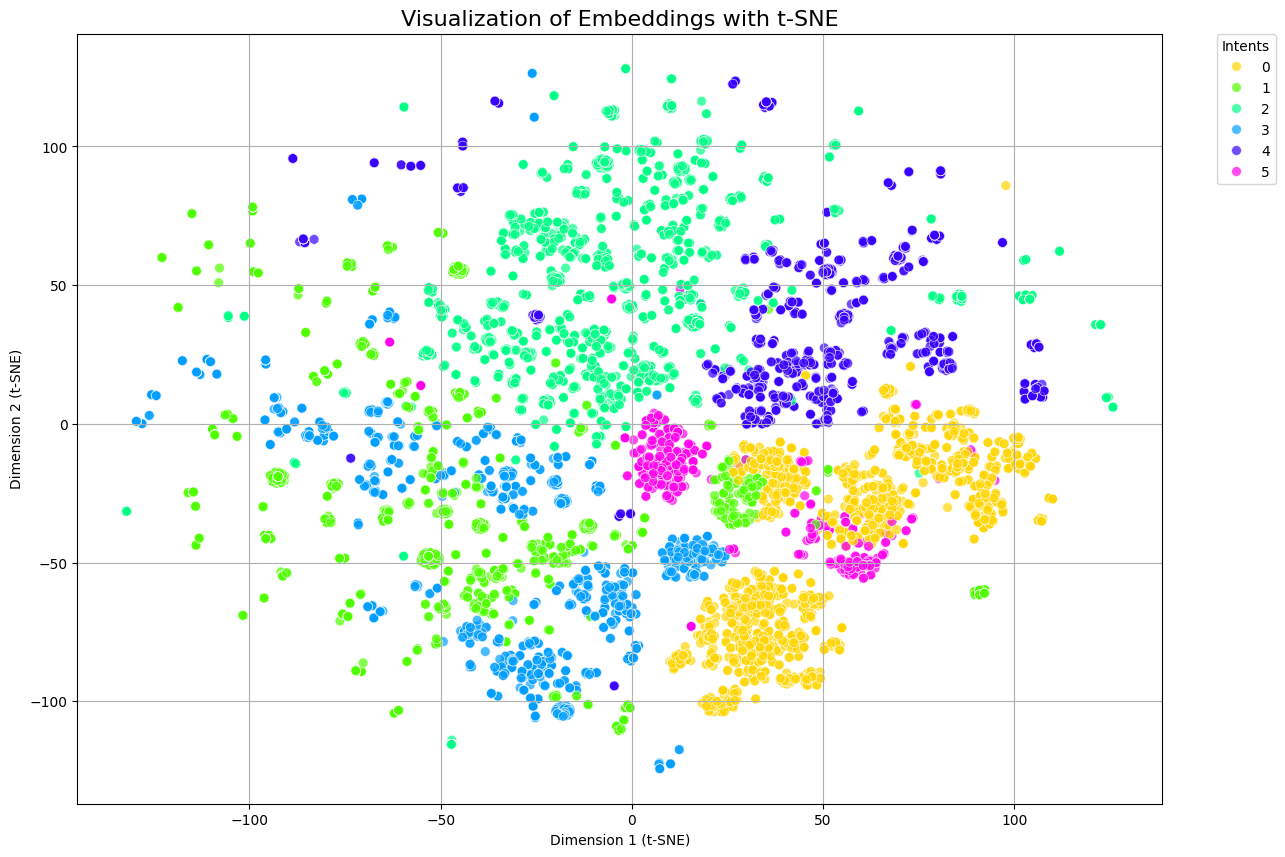

In [5]:
from sklearn.manifold import TSNE

# Visualization of Embeddings with t-SNE
# 1. Take a sample of data to speed up computation
# t-SNE is computationally intensive. 10,000 points is a good compromise.
num_samples = 10000
if len(train_labels) > num_samples:
	print(f"Using a random sample of {num_samples} points for visualization.")
	indices = np.random.choice(len(train_labels), num_samples, replace=False)
	sampled_embeddings = np.array(train_embeddings)[indices]
	sampled_labels = np.array(train_labels)[indices]
else:
	sampled_embeddings = np.array(train_embeddings)
	sampled_labels = np.array(train_labels)

# 2. Reduce dimensionality from 384 to 2 using t-SNE
print("Running t-SNE... (this may take a few minutes)")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(sampled_embeddings)

# 3. Create the scatter plot
print("Creating the plot...")
plt.figure(figsize=(14, 10))

# Use Seaborn for a nicer plot with automatic legend
sns.scatterplot(
	x=embeddings_2d[:, 0],
	y=embeddings_2d[:, 1],
	hue=sampled_labels,
	palette=sns.color_palette("hsv", len(np.unique(sampled_labels))),
	s=50, # Point size
	alpha=0.7 # Transparency
)

# Add titles and move the legend outside the plot
plt.title('Visualization of Embeddings with t-SNE', fontsize=16)
plt.xlabel('Dimension 1 (t-SNE)')
plt.ylabel('Dimension 2 (t-SNE)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Intents')
plt.grid(True)
plt.show()


In [6]:
# KNN Classifier Training
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn.fit(train_embeddings, train_labels)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'cosine'
,metric_params,None
,n_jobs,None


In [7]:
# Test embeddings generation
# Extract sentences and labels
test_utterances = list(dataset['test']['user_utterance'])
test_labels = list(dataset['test']['label'])

# Convert sentences to numerical vectors (embeddings)
test_embeddings = st_model.encode(test_utterances, show_progress_bar=True)

Batches:   0%|          | 0/459 [00:00<?, ?it/s]

In [8]:
# Get predictions from the KNN model
test_predictions = knn.predict(test_embeddings)

In [9]:
# Classification Report
target_names = sorted(set(dataset['test']['new_intent']))
report = classification_report(test_labels, test_predictions, target_names=target_names, digits=4)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       avail     0.9943    0.9964    0.9953      2466
        book     0.9970    0.9970    0.9970      2985
         bye     0.9995    0.9985    0.9990      3915
      cancel     0.9980    0.9988    0.9984      2528
       greet     0.9982    0.9986    0.9984      2180
     resched     0.9934    0.9869    0.9901       610

    accuracy                         0.9974     14684
   macro avg     0.9967    0.9960    0.9964     14684
weighted avg     0.9974    0.9974    0.9974     14684



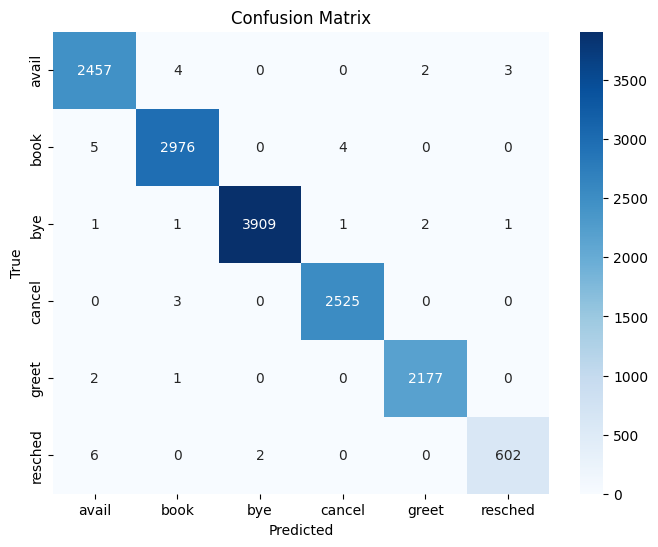

In [10]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Model Saving
model_dir = project_root / "models" / "intent_classifier"
knn_model_path = model_dir / "knn_model.joblib"
joblib.dump(knn, knn_model_path)

In [12]:
# id2label and label2id mapping saving
id2label = {i: label for i, label in enumerate(sorted(set(dataset['train']['new_intent'])))}
label2id = {label: i for i, label in id2label.items()}
with open(os.path.join(model_dir, "id2label.json"), 'w') as f:
    json.dump(id2label, f)
with open(os.path.join(model_dir, "label2id.json"), 'w') as g:
    json.dump(label2id, g)

In [ ]:
# Push to Hugging Face Hub
api = HfApi()
api.upload_folder(
    folder_path=str(model_dir),
	path_in_repo="",
	repo_id=hub_model_id,
	commit_message="Upload KNN Intent Classifier Model and Mappings",
    token=hf_token   
)